In [10]:
# import trax
# from trax import layers as tl
# import trax.fastmath.numpy as fastnp
# from trax.supervised import training
from functools import partial
import numpy as np
from itertools import combinations
import random as rnd
from random import sample
import json
import sklearn.metrics as metrics
from sklearn.metrics import classification_report , confusion_matrix, roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import copy
import torch
import os
import warnings
from scipy.spatial import distance
from os import walk
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#initialize codebert
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model_codebert = AutoModel.from_pretrained("microsoft/codebert-base").to(device)
np.random.seed(123456)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from os import walk

from transformers import AutoModelForCausalLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
v0_data_dir = '../data/test_files_v0'
v12_data_dir = '../data/test_files_v12'


# Replace the path with your own. 
filenames_v0 = next(walk(v0_data_dir), (None, None, []))[2] 
filenames_v12 = next(walk(v12_data_dir), (None, None, []))[2] 


categories =  {}
for file in filenames_v0:
    label = (file.split("@")[1]).split('.')[0].strip().lower() 
    if label not in categories.keys() : 
        categories[label] = 0
    categories[label] += 1 

for file in filenames_v12:
    label = (file.split("@")[1]).split('.')[0].strip().lower() 
    if label not in categories.keys() : 
        categories[label] = 0
    categories[label] += 1   
    
print("\n==> All data : \n")
for x , y in categories.items() :
    print(x , y)




==> All data : 

test order dependency 291
randomness 50
time 122
network 93
platform dependency 6
resource leak 28
async wait 376
test case timeout 42
concurrency 144
unordered collections 153
floating point operations 9
too restrictive range 9
i_o 6


In [13]:
from sklearn.model_selection import train_test_split
buggy_code = []
filenames = []

for file in filenames_v0:
    label = (file.split("@")[1]).split('.')[0].strip().lower() 
    if label == 'async wait':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'unordered collections':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'concurrency':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'time':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'test order dependency':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)

        
for file in filenames_v12:
    label = (file.split("@")[1]).split('.')[0].strip().lower() 
    if label == 'async wait':
        with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'unordered collections':
        with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'concurrency':
        with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'time':
        with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'test order dependency':
        with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)

        
train_buggy_code, valid_buggy_code = train_test_split(buggy_code, test_size=0.2, random_state=42)
train_filenames, valid_filenames = train_test_split(filenames,test_size=0.2,random_state=42)

In [14]:
label_to_int= {
    'async wait': 0,
    'unordered collections': 1,
    'concurrency': 2,
    'time': 3,
    'test order dependency': 4
}

In [15]:
from torch.utils.data import Dataset
import numpy as np
import random

class SiameseDataset(Dataset):
    def __init__(self, buggy_code, tokenizer, codebert, filenames, split):
        self.buggy_code = buggy_code
        self.tokenizer = tokenizer
        self.codebert = codebert.to(device)
        self.filenames = filenames
        self.split = split
        self.max_len = 0
        
        # Preprocess filenames to map labels to indices
        self.label_to_indices = {}
        for index, filename in enumerate(filenames):
            label = self._extract_label(filename)
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(index)

        # For negative sampling
        self.labels = [self._extract_label(filename) for filename in filenames]
        self.unique_labels = list(set(self.labels))

    def __len__(self):
        return len(self.buggy_code)

    def __getitem__(self, idx):
        if self.split == 'train':
            # Anchor label
            anchor_label = self._extract_label(self.filenames[idx])

            # Positive sample
            positive_idx = idx
            while positive_idx == idx:  # Ensure different indices for anchor and positive
                positive_idx = random.choice(self.label_to_indices[anchor_label])

            # Negative sample
            negative_label = random.choice([lab for lab in self.unique_labels if lab != anchor_label])
            negative_idx = random.choice(self.label_to_indices[negative_label])


            anchor = self._process_snippet(self.buggy_code[idx])
            positive = self._process_snippet(self.buggy_code[positive_idx])
            negative = self._process_snippet(self.buggy_code[negative_idx])
            if len(anchor) <= 768:
                short_data = True
            else:
                short_data = False

            return {
                'anchor': torch.nn.functional.pad(anchor, (0, 26880 - anchor.size(0))),
                'positive': torch.nn.functional.pad(positive, (0, 26880 - positive.size(0))),
                'negative': torch.nn.functional.pad(negative, (0, 26880 - negative.size(0))),
                'label': anchor_label,  # Optional, depends on how you want to use it
                'short_data_flag': short_data
            }
        elif self.split =='val':
            anchor_label = self._extract_label(self.filenames[idx])
            anchor = self._process_snippet(self.buggy_code[idx])
            
            return {
                'anchor': torch.nn.functional.pad(anchor, (0, 26880 - anchor.size(0))),
                'label': anchor_label  # Optional, depends on how you want to use it
            }
        
    def _extract_label(self, filename):
        # Implement logic to extract label from filename
        return label_to_int[(filename.split("@")[1]).split('.')[0].strip().lower()]

    def _process_snippet(self, snippet):
        import torch

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Tokenize input without the max_length constraint
        inputs = self.tokenizer(snippet, return_tensors='pt').to(device)

        if inputs['input_ids'].shape[1] < 512:

            with torch.no_grad():
                outs = self.codebert(**inputs)
            cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
            return cls  # Move to CPU to save GPU memory
        else:

            total_length = inputs['input_ids'].shape[1]
            # if total_length >= self.max_len:
            #     self.max_len = total_length
            #     print(self.max_len)
            parts = []
            step_size = 100
            chunk_size = 512

            for start_index in range(0, total_length, step_size):
                end_index = min(start_index + chunk_size, total_length)
                input_segment = {key: val[:, start_index:end_index].to(device) for key, val in inputs.items()}

                with torch.no_grad():
                    output_segment = self.codebert(**input_segment)
                cls_segment = output_segment.last_hidden_state[:, 0, :].squeeze().detach()
                parts.append(cls_segment)  # Move to CPU

                # del input_segment, output_segment, cls_segment  # Free up memory
                # torch.cuda.empty_cache()  # Clear cache
                # gc.collect()  # Invoke garbage collector

            concatenated_parts = torch.cat(parts, dim=0)
            return concatenated_parts


        
        # #CHECKING WHAT HAPPENS WHEN WE REMOVE MAX LENGTH CONSTRAINT
        # inputs = self.tokenizer(snippet, return_tensors='pt').to(device)
        # #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
        # print(inputs['input_ids'].shape[1])
        # if((inputs['input_ids'].shape[1])<512):
        #     with torch.no_grad():
        #         outs = self.codebert(**inputs)
        #     cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        #     return cls
        # else:
        #     print('longtest')
        #     i = 0
        #     part_vector =  []
        #     while ( i < (inputs['input_ids'].shape[1])-200) :
        #         print('in while')
        #         #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
        #         #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
        #         input_seg = [self.tokenizer.cls_token] + inputs['input_ids'][1][i:i+250] +[self.tokenizer.sep_token]
        #         with torch.no_grad():
        #             ots = self.codebert(**input_seg)
        #         cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
        #         #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
        #         #vector = cls[0].detach().numpy()
        #         parts.append(cls)
        #         i = i+100
        #     return parts
            
            

In [16]:

# Create instances of the custom dataset class
train_dataset = SiameseDataset(train_buggy_code, tokenizer, model_codebert, train_filenames, 'train')
val_dataset = SiameseDataset(valid_buggy_code, tokenizer, model_codebert, valid_filenames, 'val')


# Create dataloaders for training and validation
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [17]:
import numpy as np

def sample_triplet_data(data, sample_size_ratio):
    """
    Samples a subset of triplet data (anchor, positive, negative) while preserving class distribution.
    
    Parameters:
    - data: list of dictionaries, where each dictionary has keys 'anchor', 'positive', 'negative', 'label'.
    - sample_size_ratio: float, the fraction of the data to sample (0 < sample_size_ratio <= 1).
    
    Returns:
    - sampled_data: list of dictionaries, the sampled subset of the original data.
    """
    # Extract labels to understand the class distribution
    labels = [item['label'] for item in data]
    unique_classes = np.unique(labels)
    
    sampled_data = []
    
    for cls in unique_classes:
        # Find all items belonging to the current class
        class_items = [item for item in data if item['label'] == cls]
        # Calculate the number of items to sample from this class
        num_samples = int(np.ceil(len(class_items) * sample_size_ratio))
        # Randomly sample items without replacement
        sampled_items = np.random.choice(class_items, size=num_samples, replace=False)
        # Append the sampled items to the output list
        sampled_data.extend(sampled_items)
    
    # Optionally, shuffle the sampled dataset to mix classes
    np.random.shuffle(sampled_data)

    return sampled_data


In [18]:
import gc
from tqdm import tqdm
plot_data = []
plot_labels = []
short_data_flags = []
for item in tqdm(train_dataset):
    
    plot_data.append(item['anchor'])
    plot_labels.append(item['label'])
    short_data_flags.append(item['short_data_flag'])

  0%|          | 1/868 [00:00<03:02,  4.75it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1785 > 512). Running this sequence through the model will result in indexing errors


100%|██████████| 868/868 [01:01<00:00, 14.02it/s]


In [19]:

# Assuming plot_data is a list of 1D tensors of different lengths
max_length = max(tensor.size(0) for tensor in plot_data)
padded_data = [torch.nn.functional.pad(tensor, (0, max_length - tensor.size(0))) for tensor in plot_data]

In [20]:
max_length

26880

In [21]:
colors = ['#CC1D1F', '#1DCC28', '#1D37CC', '#CC9D1D', '#BA1DCC']  # Red, Green, Blue, Yellow, Purple
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Create a custom colormap
cc = LinearSegmentedColormap.from_list("cc", colors, N=5)


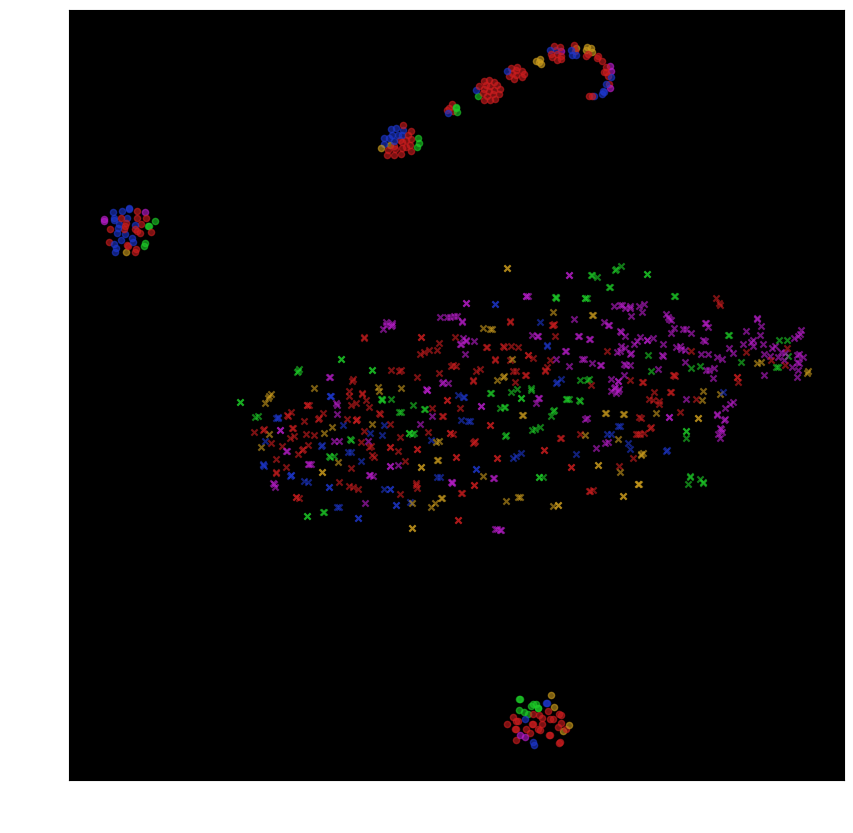

In [22]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import numpy as np

# Assuming X, plot_data, and plot_labels are defined as before
# Also assuming bool_values is your list/array of boolean values

X = torch.stack(plot_data).cpu().numpy()

# Extract labels for each point
labelsNums = plot_labels

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# Assuming 'cc' is a colormap, you might need to adjust this to fit your actual colormap variable
# Generate an array of colors for each label
unique_labels = np.unique(labelsNums)
colors = plt.cm.get_cmap(cc, len(unique_labels))  # Adjust 'cc' as needed to your colormap name
label_to_color = {label: colors(i / len(unique_labels)) for i, label in enumerate(unique_labels)}
colors_array = np.array([label_to_color[label] for label in labelsNums])

# Create the scatter plot
plt.figure(figsize=(10, 10))

# Iterate through each datapoint
for i in range(len(X_embedded)):
    marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors_array[i], s=20, alpha=0.6, marker=marker)

# Set the background color to black
plt.gca().set_facecolor('black')
# Adjust the color of the ticks and labels for better visibility
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.xlabel('Component 1', color='white')
plt.ylabel('Component 2', color='white')

plt.show()


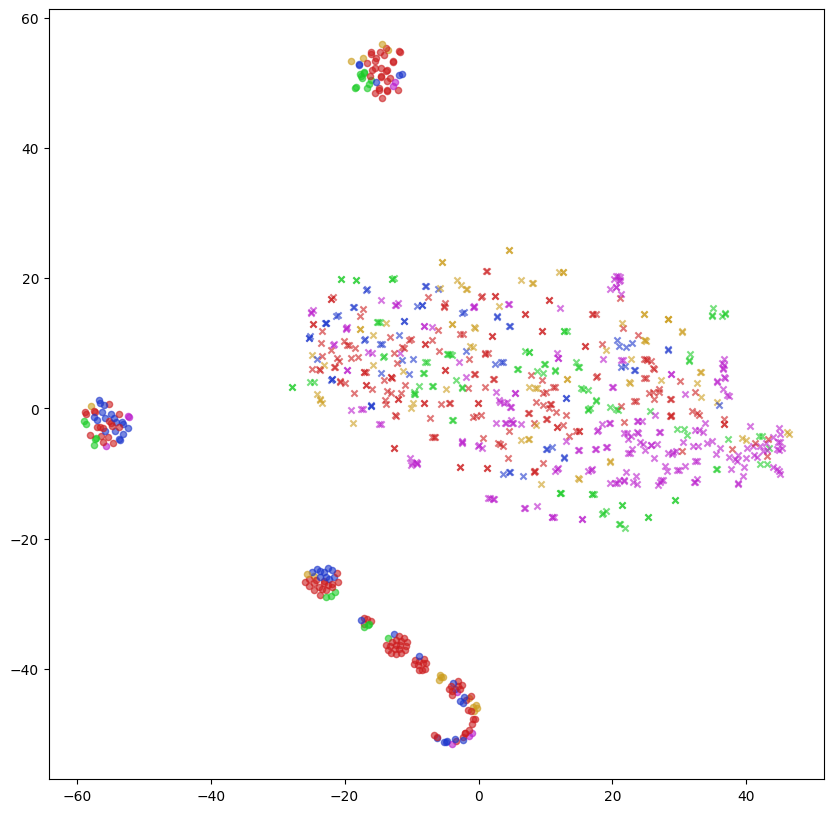

In [23]:

%matplotlib inline

X = torch.stack(plot_data).cpu().numpy()

# Extract labels for each point
labelsNums = plot_labels

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# Create the scatter plot
plt.figure(figsize=(10, 10))
#plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labelsNums[:len(X_embedded)], s=10, cmap= cc, alpha=0.6,, marker='X')
for i in range(len(X_embedded)):
    marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors_array[i], s=20, alpha=0.6, marker=marker)


# Set the background color to black
# Adjust the color of the ticks and labels for better visibility


plt.show()

In [24]:
# Load the CodeBERT tokenizer (adjust the model_name as needed)
model_name = "microsoft/codebert-base"
codebert_model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_size, int(embedding_size/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/2), int(embedding_size/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/4), embedding_size)
        )

    def forward(self, x):
        output = self.fc(x)
        return output

In [25]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [26]:
learning_rate = 1e-5
num_epochs = 450
embed_size = 26880  # This should match the output size of CodeBERT
siamese_network = SiameseNetwork(embed_size).to(device)
criterion = TripletLoss(margin=1.0)
optimizer = optim.Adam(siamese_network.parameters(), lr=learning_rate)
triplet_loss = TripletLoss().to(device)

265 epochs done already

In [65]:
best_loss = 1.0
num_epochs = 50
for epoch in range(num_epochs):
    total_loss = 0.0
    siamese_network.train()
    for batch in train_dataloader:

        labels = (batch['label']).to(device)
        batch_anchor = (batch['anchor']).to(device)
        batch_positive = (batch['positive']).to(device)
        batch_negative = (batch['negative']).to(device)

        anchor_output = siamese_network(batch_anchor)
        positive_out = siamese_network(batch_positive)
        negative_out = siamese_network(batch_negative)

        loss = criterion(anchor_output, positive_out, negative_out)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if total_loss <= best_loss:
            print("Loss improved saving model")
            torch.save(siamese_network.state_dict(), 'siamese_network_5_classes_state_dict_extratrain.pth')
            best_loss = total_loss
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")

Loss improved saving model
Loss improved saving model
Epoch 1/50, Loss: 0.04553866625652401
Loss improved saving model
Loss improved saving model
Epoch 2/50, Loss: 0.027734343885281763
Loss improved saving model
Epoch 3/50, Loss: 0.028336011351795372
Loss improved saving model
Loss improved saving model
Loss improved saving model
Loss improved saving model
Loss improved saving model
Loss improved saving model
Epoch 4/50, Loss: 0.02634624282427884
Loss improved saving model
Loss improved saving model
Loss improved saving model
Epoch 5/50, Loss: 0.024317593612802137
Loss improved saving model
Loss improved saving model
Loss improved saving model
Loss improved saving model
Loss improved saving model
Loss improved saving model
Loss improved saving model
Loss improved saving model
Loss improved saving model
Loss improved saving model
Loss improved saving model
Loss improved saving model
Loss improved saving model
Epoch 6/50, Loss: 0.04480982264247509
Epoch 7/50, Loss: 0.055965169102226923
L

KeyboardInterrupt: 

In [1]:
torch.save(siamese_network.state_dict(), 'siamese_network_5_classes_state_dict_extratrain.pth')

NameError: name 'torch' is not defined

In [28]:
siamese_network.load_state_dict(torch.load('/home/riddhi/MAIN_SDP/Concurrency_bug/MAIN/siamese_network_5_classes_state_dict_extratrain.pth'))


<All keys matched successfully>

In [29]:
siamese_network.eval() 
post_train_embed = []
post_train_label = []
with torch.no_grad():
    for item in tqdm(train_dataset):
        post_train_embed.append(siamese_network(item['anchor']))
        post_train_label.append(item['label'])

100%|██████████| 868/868 [01:04<00:00, 13.47it/s]


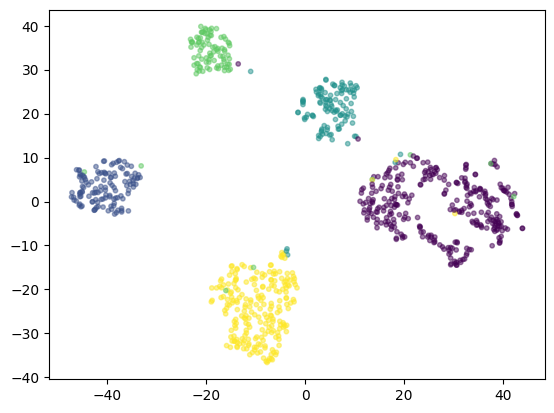

In [30]:
%matplotlib inline

X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label
X_embedded= TSNE(n_components=2, init='random').fit_transform(X_np)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1] , c=labelsNums[:len(X_embedded)], s=10, cmap='viridis' , alpha=0.5 );


In [32]:
def clsembed(snippet):
    inputs = tokenizer(snippet, padding='max_length', max_length=218, truncation=True, return_tensors='pt').to(device)
    #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
    if(len(inputs)<512):
        with torch.no_grad():
            outs = model_codebert(**inputs)
        cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        return cls
    else:
        print('longtest')
        i = 0
        part_vector =  []
        while ( i < len(inputs)-200) :
            #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
            #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
            input_seg = [tokenizer.cls_token] + inputs[i:i+250] +[tokenizer.sep_token]
            with torch.no_grad():
                ots = model_codebert(**input_seg)
            cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
            #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
            #vector = cls[0].detach().numpy()
            parts.append(cls)
            i = i+100
        return parts

In [33]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
#labels_all = ['async wait','unordered collections','concurrency','time']
def get_class_rep(post_train_embed, post_train_label):
    # Move each tensor to CPU, convert to numpy, and collect in a list
    #post_train_embed = [x.cpu().numpy() for x in post_train_embed]
    # If you want to combine them into a single array (assuming they have the same shape)
    #post_train_embed = np.concatenate(post_train_embed, axis=0)
    representatives = [None] * 5
    for label in range(5):
        indices = np.where(np.atleast_1d(post_train_label) == label)[0]  # Get the indices as an array
        class_vectors = [post_train_embed[i] for i in indices]  # Access each index individually
        class_vectors = [x.cpu().numpy() for x in class_vectors]
        representatives[label] = np.mean(class_vectors, axis=0)
    return representatives

def calculate_normalized_distance(vec1, vec2):
    # Ensure vec1 and vec2 are numpy arrays
    if not isinstance(vec1, np.ndarray):
        vec1 = vec1.cpu().detach().numpy()
    if not isinstance(vec2, np.ndarray):
        vec2 = vec2.cpu().detach().numpy()
    
    # Normalize each vector to have unit length
    norm_vec1 = vec1 / np.linalg.norm(vec1)
    norm_vec2 = vec2 / np.linalg.norm(vec2)
    
    # Calculate Euclidean (L2) distance between the normalized vectors
    distance = np.linalg.norm(norm_vec1 - norm_vec2)
    
    return distance


In [34]:
int_to_label={
    0: 'async wait',
    1: 'unordered collections',
    2: 'concurrency',
    3: 'time',
    4: 'test order dependency'
}


def get_closest_cluster(cluster_representatives, projected_vector):
    distances = [calculate_normalized_distance(rep, projected_vector) for rep in cluster_representatives]
    for i in range(len(distances)):
        distances[i] = np.mean(distances[i])
    closest_cluster_idx = np.argmin(distances)
    return int_to_label[closest_cluster_idx]

In [35]:
embed = post_train_embed
labels = post_train_label
def predict(input_vector):
    modified_vector = siamese_network(input_vector)
    representatives = get_class_rep(embed, labels)
    return get_closest_cluster(representatives, modified_vector)
    
print(predict(train_dataset[10]['anchor']))   
    
print(int_to_label[train_dataset[10]['label']])

async wait
async wait


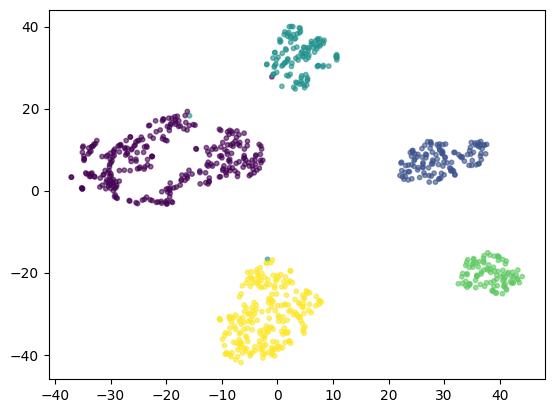

In [74]:
#previous best result learing rate: 1e-5
%matplotlib inline

X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label
X_embedded= TSNE(n_components=2, init='random').fit_transform(X_np)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1] , c=labelsNums[:len(X_embedded)], s=10, cmap='viridis' , alpha=0.6 );


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


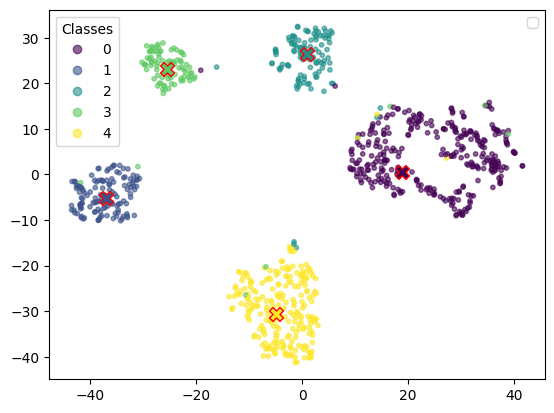

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch

# Assuming post_train_embed, post_train_label, and labelsNums are defined
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np)

# Plot the data points
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labelsNums[:len(X_embedded)], s=10, cmap='viridis', alpha=0.6)

# Calculate class representatives
representatives = get_class_rep(post_train_embed, post_train_label)  # Make sure this function returns what you expect

# Get unique labels and their colors from the scatter plot
unique_labels = np.unique(labelsNums[:len(X_embedded)])
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# For each class representative, find the closest point and plot it
for i, rep in enumerate(representatives):
    if rep is not None:
        # Find the closest data point in the original space to this representative
        distances = np.linalg.norm(X_np - rep, axis=1)
        closest_point_index = np.argmin(distances)
        # Use the label of the closest data point to get the correct color
        label_of_closest = labelsNums[closest_point_index]
        color = scatter.cmap(scatter.norm(label_of_closest))
        plt.scatter(X_embedded[closest_point_index, 0], X_embedded[closest_point_index, 1], color=color, edgecolors='red', s=100, marker='X')

# You might want to adjust the legend to make sure it correctly represents your data
plt.legend()
plt.show()


In [76]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Assuming 'X_embedded' is your t-SNE result and 'labelsNums' are your labels

# Silhouette Score:
# - Measures how similar an object is to its own cluster compared to other clusters.
# - Range: -1 (incorrect clustering) to 1 (highly dense clustering). 
#   A score close to 1 means that the clusters are well separated and clearly defined.
silhouette_avg = silhouette_score(X_embedded, labelsNums[:len(X_embedded)])
print(f"Silhouette Score: {silhouette_avg}")

# Davies-Bouldin Index:
# - Evaluates the clustering quality by measuring the average 'similarity' between each cluster 
#   and its most similar one. The similarity is based on a ratio of within-cluster distances to between-cluster distances.
# - Range: 0 to +∞. Lower scores indicate better clustering quality.
davies_bouldin = davies_bouldin_score(X_embedded, labelsNums[:len(X_embedded)])
print(f"Davies-Bouldin Index: {davies_bouldin}")

# Calinski-Harabasz Index:
# - Measures the cluster validity based on the ratio between the within-cluster dispersion and the between-cluster dispersion.
# - Range: Higher values indicate better clustering quality, with no upper limit. Low values indicate clusters with high overlap.
calinski_harabasz = calinski_harabasz_score(X_embedded, labelsNums[:len(X_embedded)])
print(f"Calinski-Harabasz Index: {calinski_harabasz}")


Silhouette Score: 0.7048224806785583
Davies-Bouldin Index: 0.39300463242088485
Calinski-Harabasz Index: 2862.663563155017


In [37]:
from sklearn.metrics import f1_score

int_to_label={
    0: 'async wait',
    1: 'unordered collections',
    2: 'concurrency',
    3: 'time',
    4: 'test order dependency'
}
count = 0

# Assuming val_dataset is iterable and has 'anchor' and 'label' keys
predicted_labels = []
true_labels = []

for item in val_dataset:
    count+=1
    input_vector = item['anchor']  # Your input vector for prediction
    predicted_label = predict(input_vector)  # Get predicted cluster/label
    predicted_labels.append(predicted_label)
    
    true_label = item['label']  # True label
    true_label = int_to_label[int(true_label)]
    true_labels.append(true_label)
    print(count, " ",predicted_label, " " ,true_label)
# Convert predicted labels to the same format as true_labels if necessary
# This might include converting cluster IDs to the label format, depending on how your `predict` function outputs the prediction

# Note: Ensure that your predict function returns labels in a format that matches true_labels or adjust accordingly
print("loop completed")
# Calculate F1 Score
f1 = f1_score(true_labels, predicted_labels, average='weighted')  # Adjust 'average' as necessary
print(f"F1 Score: {f1}")


1   unordered collections   unordered collections
2   test order dependency   test order dependency
3   async wait   async wait
4   unordered collections   unordered collections
5   concurrency   async wait
6   test order dependency   test order dependency
7   concurrency   concurrency
8   time   time
9   test order dependency   test order dependency
10   async wait   async wait
11   unordered collections   unordered collections
12   time   time
13   test order dependency   test order dependency
14   test order dependency   test order dependency
15   concurrency   concurrency
16   time   time
17   test order dependency   test order dependency
18   unordered collections   unordered collections
19   async wait   async wait
20   concurrency   async wait
21   async wait   async wait
22   test order dependency   test order dependency
23   async wait   async wait
24   time   time
25   async wait   async wait
26   test order dependency   test order dependency
27   async wait   async wait
28  

                       precision    recall  f1-score   support

           async wait       0.98      0.92      0.95        65
          concurrency       0.90      0.97      0.93        29
test order dependency       0.99      1.00      0.99        66
                 time       0.93      0.93      0.93        29
unordered collections       0.97      1.00      0.98        29

             accuracy                           0.96       218
            macro avg       0.95      0.96      0.96       218
         weighted avg       0.96      0.96      0.96       218


 - Accuracy :  0.96
 - Precision :  0.96
 - Recall :  0.96
 - F1 score :  0.96
 - MCC :  0.95
 - AUC :  0.98


Perfomnaces by categories



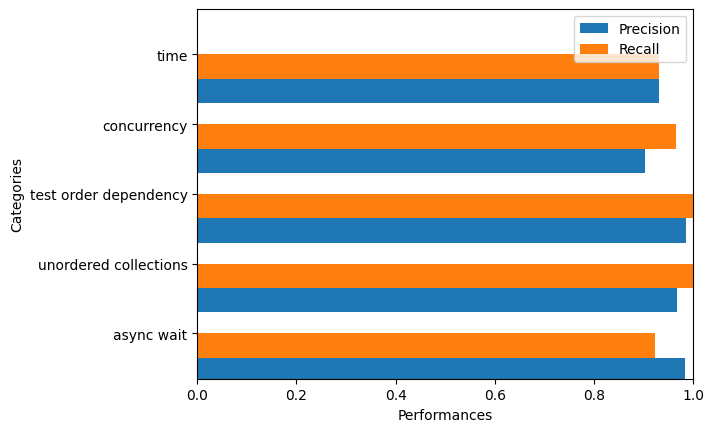



Confusion Matrix 


<AxesSubplot:>

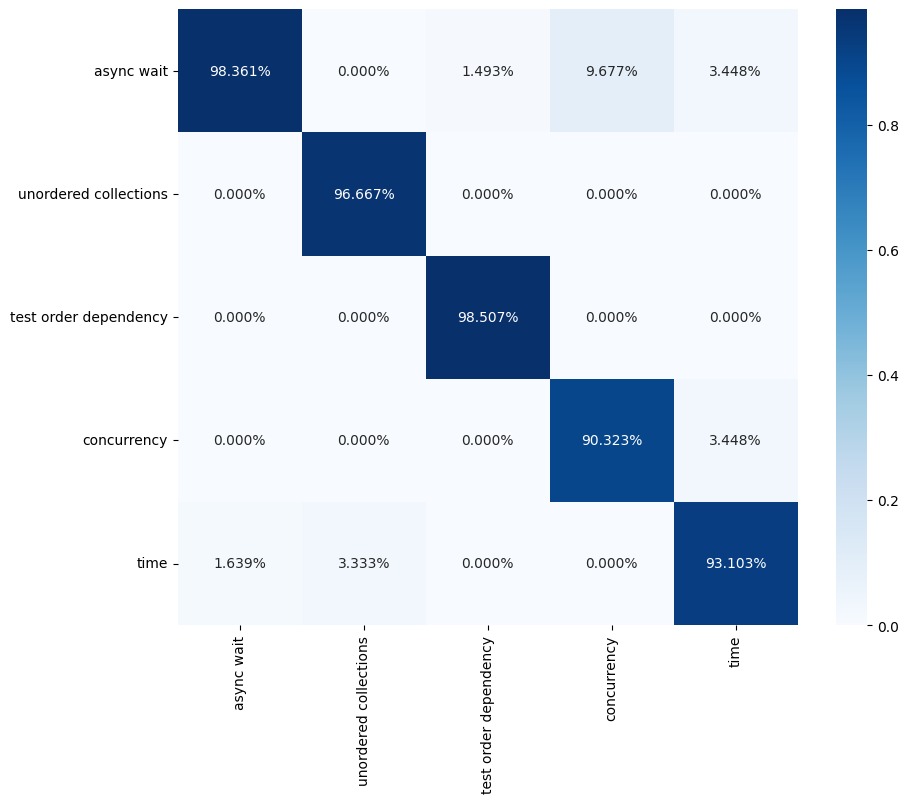

In [39]:
%matplotlib inline
warnings.filterwarnings("ignore")
def multiclass_roc_auc_score(truth, pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)


predicted = predicted_labels
labels = true_labels
unique_labels = list ( set(labels ) )
print (classification_report(labels, predicted))

print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels,  predicted) , 2))
print(' - Precision : ' , np.round( metrics.precision_score(labels,  predicted , average='weighted') , 2))
print(' - Recall : ' , np.round( metrics.recall_score(labels,  predicted , average='weighted') , 2))
print(' - F1 score : ' , np.round( metrics.f1_score(labels,  predicted , average='weighted') , 2))
print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels,  predicted) , 2))
print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels,  predicted),2) )

print("\n\nPerfomnaces by categories\n")


ind = np.arange(len(unique_labels)) 
width = 0.35
fig, ax = plt.subplots()
precision = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[0]
recall = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[1]
ax.barh(ind - width/2, precision, width, label='Precision')
ax.barh(ind + width/2, recall, width, label='Recall')
ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
ylim=[2*width - 1, len(ind)])
plt.xlim(0,1)
ax.legend(loc='upper right')
ax.set_xlabel("Performances")
ax.set_ylabel("Categories")
plt.show()

print("\n\nConfusion Matrix ")

mat = confusion_matrix(labels,  predicted, labels=unique_labels)
df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
plt.figure(figsize = (10,8))
sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

                       precision    recall  f1-score   support

           async wait       0.95      0.87      0.91        71
          concurrency       0.77      0.89      0.83        27
test order dependency       0.91      0.97      0.94        64
                 time       0.83      0.70      0.76        27
unordered collections       0.90      0.97      0.93        29

             accuracy                           0.89       218
            macro avg       0.87      0.88      0.87       218
         weighted avg       0.90      0.89      0.89       218


 - Accuracy :  0.71
 - Precision :  0.72
 - Recall :  0.71
 - F1 score :  0.71
 - MCC :  0.62
 - AUC :  0.82


Perfomnaces by categories



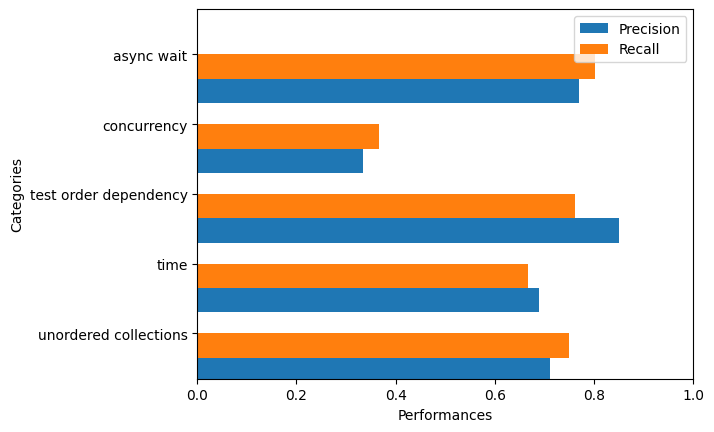



Confusion Matrix 


<Axes: >

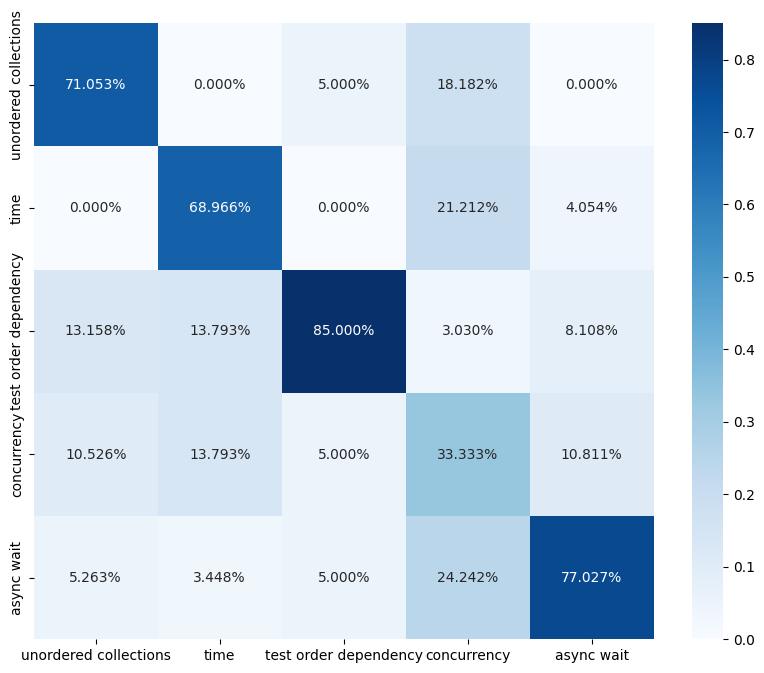

In [153]:
file_path = 'test_data_predictions.csv'

# Load the compressed CSV file into a DataFrame
df = pd.read_csv(file_path)

# Extract the 'TrueLabel' and 'PredictedLabel' columns into separate variables
labels_flaky = df['TrueLabel'].tolist()
predicted_flaky = df['PredictedLabel'].tolist()

print (classification_report(labels, predicted))

print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels_flaky,  predicted_flaky) , 2))
print(' - Precision : ' , np.round( metrics.precision_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
print(' - Recall : ' , np.round( metrics.recall_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
print(' - F1 score : ' , np.round( metrics.f1_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels_flaky,  predicted_flaky) , 2))
print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels_flaky,  predicted_flaky),2) )

print("\n\nPerfomnaces by categories\n")


ind = np.arange(len(unique_labels)) 
width = 0.35
fig, ax = plt.subplots()
precision = metrics.precision_recall_fscore_support(labels_flaky,  predicted_flaky ,  labels=unique_labels )[0]
recall = metrics.precision_recall_fscore_support(labels_flaky,  predicted_flaky ,  labels=unique_labels )[1]
ax.barh(ind - width/2, precision, width, label='Precision')
ax.barh(ind + width/2, recall, width, label='Recall')
ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
ylim=[2*width - 1, len(ind)])
plt.xlim(0,1)
ax.legend(loc='upper right')
ax.set_xlabel("Performances")
ax.set_ylabel("Categories")
plt.show()

print("\n\nConfusion Matrix ")

mat = confusion_matrix(labels_flaky,  predicted_flaky, labels=unique_labels)
df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
plt.figure(figsize = (10,8))
sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

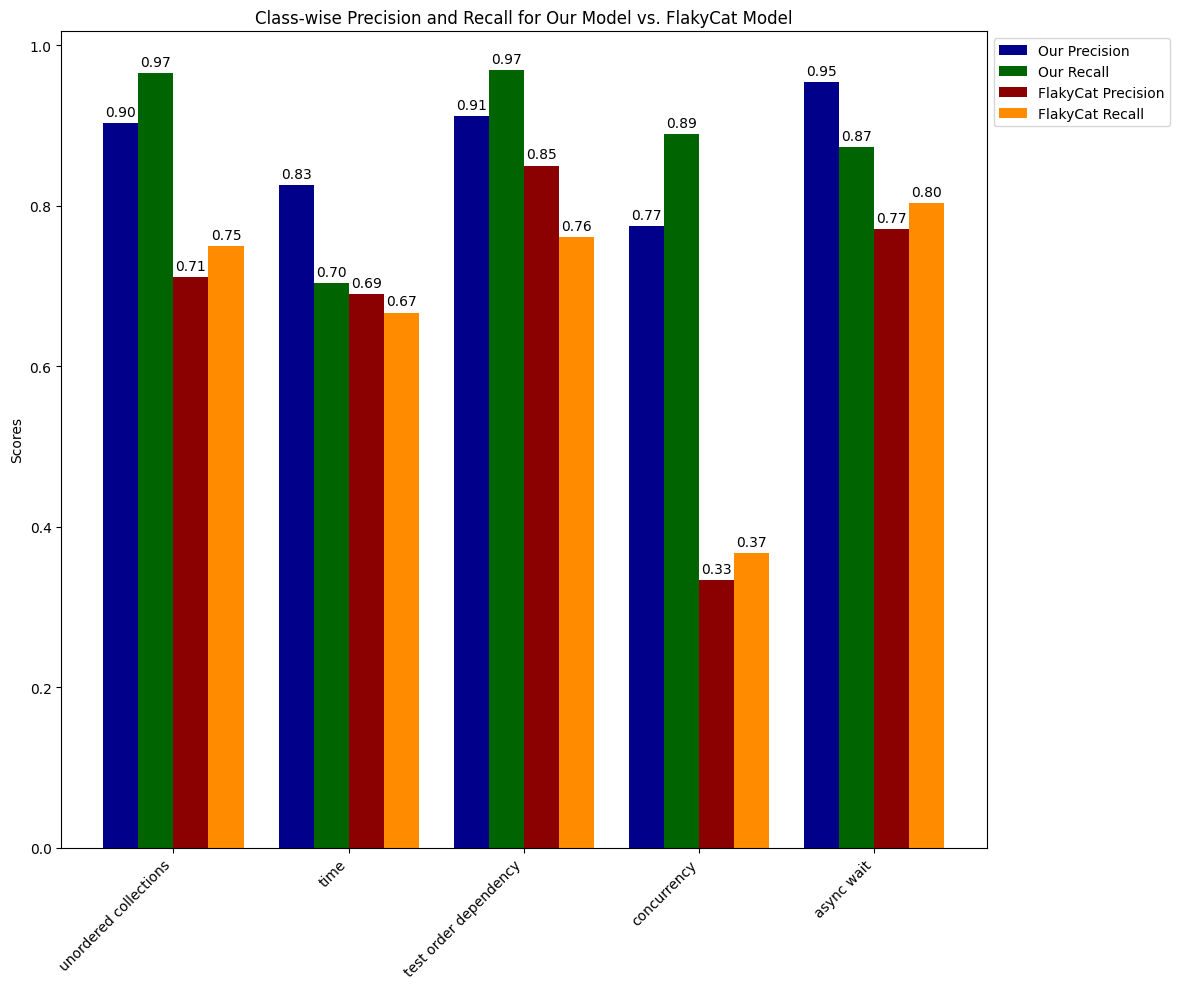

In [154]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

precision_our_model = metrics.precision_recall_fscore_support(labels, predicted, labels=unique_labels)[0]
recall_our_model = metrics.precision_recall_fscore_support(labels, predicted, labels=unique_labels)[1]
# And assuming 'unique_labels' is defined as before

ind = np.arange(len(unique_labels))  # the x locations for the groups
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 10))  # Adjust the figure size as needed

# Using a set of contrasting, darker colors
colors = ['blue', 'green', 'red', 'orange']

# Plotting Precision and Recall for Your Model
rects1 = ax.bar(ind - width*1.5, precision_our_model, width, label='Our Precision', color=colors[0])
rects2 = ax.bar(ind - width/2, recall_our_model, width, label='Our Recall', color=colors[1])

# Plotting Precision and Recall for Flaky Model
rects3 = ax.bar(ind + width/2, precision_flaky, width, label='FlakyCat Precision', color=colors[2])
rects4 = ax.bar(ind + width*1.5, recall_flaky, width, label='FlakyCat Recall', color=colors[3])

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Class-wise Precision and Recall for Our Model vs. FlakyCat Model')
ax.set_xticks(ind)
ax.set_xticklabels(unique_labels, rotation=45, ha="right")  # Rotate for better label visibility
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place the legend outside the figure

# Optional: Adding scores above bars
ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')
ax.bar_label(rects3, padding=3, fmt='%.2f')
ax.bar_label(rects4, padding=3, fmt='%.2f')

fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to make space for the legend outside

plt.show()


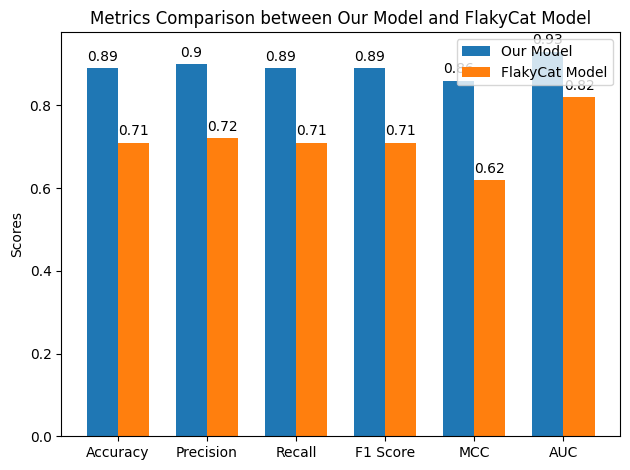

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming metrics have been calculated and stored in variables for both models.
# Example metric variables: accuracy, precision, recall, f1_score, mcc, auc for the original model
# And similarly named variables with a '_flaky' suffix for the comparison model.

metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', 'AUC']
your_model_metrics = [
    np.round(metrics.accuracy_score(labels, predicted), 2),
    np.round(metrics.precision_score(labels, predicted, average='weighted'), 2),
    np.round(metrics.recall_score(labels, predicted, average='weighted'), 2),
    np.round(metrics.f1_score(labels, predicted, average='weighted'), 2),
    np.round(metrics.matthews_corrcoef(labels, predicted), 2),
    np.round(multiclass_roc_auc_score(labels, predicted), 2)
]

flaky_model_metrics = [
    np.round(metrics.accuracy_score(labels_flaky, predicted_flaky), 2),
    np.round(metrics.precision_score(labels_flaky, predicted_flaky, average='weighted'), 2),
    np.round(metrics.recall_score(labels_flaky, predicted_flaky, average='weighted'), 2),
    np.round(metrics.f1_score(labels_flaky, predicted_flaky, average='weighted'), 2),
    np.round(metrics.matthews_corrcoef(labels_flaky, predicted_flaky), 2),
    np.round(multiclass_roc_auc_score(labels_flaky, predicted_flaky), 2)
]

x = np.arange(len(metrics_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, your_model_metrics, width, label='Our Model')
rects2 = ax.bar(x + width/2, flaky_model_metrics, width, label='FlakyCat Model')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Metrics Comparison between Our Model and FlakyCat Model')
ax.set_xticks(x)
ax.set_xticklabels(metrics_labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()
